# Twitter Multi-lass text classification guided by CRISP DM Methodology

# Introduction

This project's aim, is to explore the world of *Natural Language Processing* (NLP) by building what is known as a **Sentiment Analysis Model**. A sentiment analysis model is a model that analyses a given piece of text and predicts whether this piece of text expresses positive or negative sentiment.

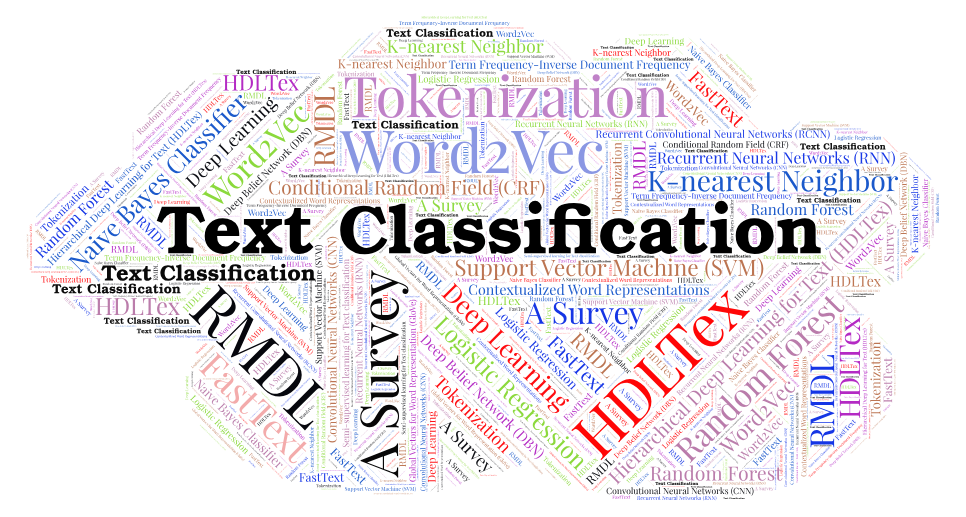
To this end, we will be using the `sentiment140` dataset containing data collected from twitter. An impressive feature of this dataset is that it is *perfectly* balanced (i.e., the number of examples in each class is equal).

Citing the [creators](http://help.sentiment140.com/for-students/) of this dataset:

> *Our approach was unique because our training data was automatically created, as opposed to having humans manual annotate tweets. In our approach, we assume that any tweet with positive emoticons, like :), were positive, and tweets with negative emoticons, like :(, were negative. We used the Twitter Search API to collect these tweets by using keyword search*

After a series of **cleaning and data processing**, and after visualizing our data in a **word cloud**, we will be building a **Naive Bayezian** model. This model's goal would be to properly classify positive and negative tweets in terms of sentiment.
Next, we will propose a much more advanced solution using a **deep learning** model: **LSTM**. This process will require a different kind of data cleaning and processing. Also, we will discover **Word Embeddings**, **Dropout** and many other machine learning related concepts.

Throughout this notebook, we will take advantage of every result, visualization and failure in order to try and further understand the data, extract insights and information from it and learn how to improve our model. From the type of words used in positive/negative sentiment tweets, to the vocabulary diversity in each case and the day of the week in which these tweets occur, to the overfitting concept and grasping the huge importance of the data while building a given model, I really hope that you'll enjoy going through this notebook and gain not only technical skills but also analytical skills from it.

---

This notebook is written by **Joseph Assaker**. Feel free to reach out for any feedback on this notebook via [email](mailto:lb.josephassaker@gmail.com) or [LinkedIn](https://www.linkedin.com/in/joseph-assaker/).

---

Now, let's start with the fun 🎉

### **Table of Content:**

 1. [Importing and Discovering the Dataset](#head-1)  
 2. [Cleaning and Processing the Data](#head-2)  
  2.1. [Tokenization](#head-2-1)  
  2.2. [Lemmatization](#head-2-2)  
  2.3. [Cleaning the Data](#head-2-3)  
 3. [Visualizing the Data](#head-3)
 4. [Naive Bayesian Model](#head-4)  
  4.1. [Splitting the Data](#head-4-1)  
  4.2. [Training the Model](#head-4-2)  
  4.3. [Testing the Model](#head-4-3)  
  4.4. [Asserting the Model](#head-4-4)    
 5. [Deep Learning Model - LSTM](#head-5)  
  5.1. [Data Pre-processing](#head-5-1)  
&nbsp;&nbsp;&nbsp;&nbsp;5.1.1. [Word Embeddings](#head-5-1-1)  
&nbsp;&nbsp;&nbsp;&nbsp;5.1.2. [Global Vectors for Word Representation (GloVe)](#head-5-1-2)  
&nbsp;&nbsp;&nbsp;&nbsp;5.1.3. [Data Padding](#head-5-1-3)  
  5.2. [Data Transformation](#head-5-2)  
  5.3. [Building the Model](#head-5-3)  
  5.4. [Training the Model](#head-5-4)  
  5.5. [Investigating Possibilties to Improve the Model](#head-5-5)  
&nbsp;&nbsp;&nbsp;&nbsp;5.5.1. [Regularization - Dropout](#head-5-5-1)  
&nbsp;&nbsp;&nbsp;&nbsp;5.5.2. [Inspecting the Data - Unknown Words](#head-5-5-2)  
  5.6. [Predicting on Custom Data](#head-5-6)  
  5.7. [Inspecting Wrongly Predicted Data](#head-5-7)  
 6. [Bonus Section](#head-6)
 7. [Extra Tip: Pickling !](#head-7)
 8. [Further Work](#head-8)

# 1. Importing and Discovering the Dataset <a class="anchor" id="head-1"></a>

In [143]:
#Import libraries
print("Importing neccesary  and packages and libraries......")
from time import time
import random
import json
import tabulate
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from gensim.utils import simple_preprocess
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

print("Done")

Importing neccesary  and packages and libraries......
Done


In [158]:
import pandas as pd
import json
from tabulate import tabulate

# Load JSON data from the file
with open('./data/CETM47-22_23-AS2-Data.json', 'r', encoding='utf-8') as file:
    tweets_data = json.load(file)

# Create lists to store attribute values
texts = []
dates = []
labels = []
ids = []
label_names = []

# Iterate through the tweets data and extract attribute values
for tweet in tweets_data:
    texts.append(tweet['text'])
    dates.append(tweet['date'])
    labels.append(tweet['label'])
    ids.append(tweet['id'])
    label_names.append(tweet['label_name'])

# Create a DataFrame using the extracted data
data = {
    'text': texts,
    'date': dates,
    'label': labels,
    'id': ids,
    'label_name': label_names
}
df = pd.DataFrame(data)

# Display the DataFrame as a table
table = tabulate(df.head(20), headers='keys', tablefmt='psql')
print(table)


+----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+---------+---------------------+-----------------+
|    | text                                                                                                                                                                                                                                                                                              | date       |   label |                  id | label_name      |
|----+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [160]:
# Assign label names
label_names = {
    0: "Arts & Culture",
    1: "Business & Entrepreneurs",
    2: "Pop Culture",
    3: "Daily Life",
    4: "Sports & Gaming",
    5: "Science & Technology"
}

# Map label codes to label names
df['label_name'] = df['label'].map(label_names)

# Display the count of tweets for each category
category_tweet_counts = df['label_name'].value_counts()
print(category_tweet_counts)

label_name
Pop Culture                 2512
Sports & Gaming             2291
Daily Life                   883
Science & Technology         326
Business & Entrepreneurs     287
Arts & Culture               144
Name: count, dtype: int64


In [162]:

# Drop all columns except 'text' and 'label_name'
filtered_df = df[['text', 'label_name']]

# Display the filtered DataFrame
print(filtered_df.head(10))


                                                text       label_name
0  The {@Clinton LumberKings@} beat the {@Cedar R...  Sports & Gaming
1  I would rather hear Eli Gold announce this Aub...  Sports & Gaming
2  Someone take my phone away, I’m trying to not ...  Sports & Gaming
3  A year ago, Louisville struggled to beat an FC...  Sports & Gaming
4  Anyone know why the #Dodgers #Orioles game nex...  Sports & Gaming
5  I don’t care. you gave him a shot, he is strug...  Sports & Gaming
6  Okay how can I watch the {@Arkansas State Foot...  Sports & Gaming
7  Check out largest crowds ever for a basketball...  Sports & Gaming
8  I voted #WeWantNCAAFootball on {{USERNAME}} . ...  Sports & Gaming
9  Streaming a new game #minionmasters come stop ...  Sports & Gaming


# 2. Cleaning and Processing the Data <a class="anchor" id="head-2"></a>

## 2.1. Tokenization <a class="anchor" id="head-2-1"></a>

In order to feed our text data to a classification model, we first need to *tokenize* it.  
**Tokenization** is the process of splitting up a single string of text into a list of individual words, or *tokens*.
<br>

Python has a built in string method: *string.split()*, that splits up any given string into a list based on a splitting character (if not specified, will default to *white space*).
<br>

In this example, we will use the **TweetTokenizer**; a Twitter-aware tokenizer provided by the *nltk* library. In addition to a standard tokenizer, this tokenizer will split the input text based on various criterions that are well suited for the tweets use case.

More info can be found at: https://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize.casual.

In [164]:
import pandas as pd

# Assuming you have already filtered the DataFrame as shown in the previous response
# Replace 'filtered_df' with the actual name of your filtered DataFrame
tokenized_text = [text.split() for text in filtered_df['text']]
tokenized_df = pd.DataFrame({'tokenized_text': tokenized_text, 'label_name': filtered_df['label_name']})

# Display the first 10 rows of the tokenized DataFrame
print(tokenized_df.head(10))


                                      tokenized_text       label_name
0  [The, {@Clinton, LumberKings@}, beat, the, {@C...  Sports & Gaming
1  [I, would, rather, hear, Eli, Gold, announce, ...  Sports & Gaming
2  [Someone, take, my, phone, away,, I’m, trying,...  Sports & Gaming
3  [A, year, ago,, Louisville, struggled, to, bea...  Sports & Gaming
4  [Anyone, know, why, the, #Dodgers, #Orioles, g...  Sports & Gaming
5  [I, don’t, care., you, gave, him, a, shot,, he...  Sports & Gaming
6  [Okay, how, can, I, watch, the, {@Arkansas, St...  Sports & Gaming
7  [Check, out, largest, crowds, ever, for, a, ba...  Sports & Gaming
8  [I, voted, #WeWantNCAAFootball, on, {{USERNAME...  Sports & Gaming
9  [Streaming, a, new, game, #minionmasters, come...  Sports & Gaming


## 2.2. Lemmatization <a class="anchor" id="head-2-2"></a>

According to the Cambridge English Dictionary, **Lemmatization** is the process of reducing the different forms of a word to one single form, for example, reducing "builds", "building", or "built" to the lemma "build". This will greatly help our classifier by treating all variants of a given word as being references to the original lemma word. For example, it will avoid interpreting "running" and "run" as completely different inputs.
<br>

In this example, we will use *nltk*'s **WordNetLemmatizer** to accomplish this task. This lemmatizer however takes as input two arguments: a list of tokens to be lemmatized as well as their corresponding *part of speech*. The most common parts of speech in english are nouns and verbs. In order to extract each token's part of speech, we will utilize *nltk*'s *post_tag* function, that takes an input a list of tokens, and returns a list of tuples, where each tuple is composed of a token and its corresponding position tag. Various position tags can be outputted from the pos_tag function, however the most notable ones are:
* **NNP**: Noun, proper, singular
* **NN**: Noun, common, singular or mass.
* **VBG**: Verb, gerund or present participle.
* **VBN**: Verb, past participle.

A full list of position tags can be found at: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [166]:
import pandas as pd
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

# Function to perform lemmatization
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

# Apply lemmatization to the 'tokenized_text' column
tokenized_df['lemmatized_text'] = tokenized_df['tokenized_text'].apply(lemmatize_tokens)

# Create the new DataFrame 'lemmatized_df' with 'lemmatized_text' and 'label_name' columns
lemmatized_df = tokenized_df[['lemmatized_text', 'label_name']].copy()

# Display the first 10 rows of the lemmatized DataFrame
print(lemmatized_df.head(10))

# Save the lemmatized DataFrame as a binary file (Pickle format)
lemmatized_df.to_pickle('lemmatized_data.pkl')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                     lemmatized_text       label_name
0  [The, {@Clinton, LumberKings@}, beat, the, {@C...  Sports & Gaming
1  [I, would, rather, hear, Eli, Gold, announce, ...  Sports & Gaming
2  [Someone, take, my, phone, away,, I’m, trying,...  Sports & Gaming
3  [A, year, ago,, Louisville, struggled, to, bea...  Sports & Gaming
4  [Anyone, know, why, the, #Dodgers, #Orioles, g...  Sports & Gaming
5  [I, don’t, care., you, gave, him, a, shot,, he...  Sports & Gaming
6  [Okay, how, can, I, watch, the, {@Arkansas, St...  Sports & Gaming
7  [Check, out, largest, crowd, ever, for, a, bas...  Sports & Gaming
8  [I, voted, #WeWantNCAAFootball, on, {{USERNAME...  Sports & Gaming
9  [Streaming, a, new, game, #minionmasters, come...  Sports & Gaming


## 2.3. Cleaning the Data <a class="anchor" id="head-2-3"></a>

In [170]:
import pandas as pd

# Load the lemmatized DataFrame from the saved Pickle file
lemmatized_df = pd.read_pickle('lemmatized_data.pkl')

# List of words to remove
words_to_remove = ["the", "a", "an", "in", "url", "URL", "Username", "USERNAME", "username", "Url"]

# Function to clean tokens by removing specific words
def clean_tokens(tokens):
    cleaned_tokens = [token for token in tokens if token.lower() not in words_to_remove]
    return cleaned_tokens

# Apply token cleaning to the 'lemmatized_text' column
lemmatized_df['cleaned_text'] = lemmatized_df['lemmatized_text'].apply(clean_tokens)

# Create a new DataFrame 'cleaned_df' with 'cleaned_text' and 'label_name' columns
cleaned_df = lemmatized_df[['cleaned_text', 'label_name']]

# Display the first 10 rows of the cleaned DataFrame
print(cleaned_df.head(10))

# Save the cleaned DataFrame as a binary file (Pickle format)
cleaned_df.to_pickle('cleaned_data.pkl')


                                        cleaned_text       label_name
0  [{@Clinton, LumberKings@}, beat, {@Cedar, Rapi...  Sports & Gaming
1  [I, would, rather, hear, Eli, Gold, announce, ...  Sports & Gaming
2  [Someone, take, my, phone, away,, I’m, trying,...  Sports & Gaming
3  [year, ago,, Louisville, struggled, to, beat, ...  Sports & Gaming
4  [Anyone, know, why, #Dodgers, #Orioles, game, ...  Sports & Gaming
5  [I, don’t, care., you, gave, him, shot,, he, i...  Sports & Gaming
6  [Okay, how, can, I, watch, {@Arkansas, State, ...  Sports & Gaming
7  [Check, out, largest, crowd, ever, for, basket...  Sports & Gaming
8  [I, voted, #WeWantNCAAFootball, on, {{USERNAME...  Sports & Gaming
9  [Streaming, new, game, #minionmasters, come, s...  Sports & Gaming


In [171]:
import pandas as pd

# Load the cleaned DataFrame from the saved Pickle file
cleaned_df = pd.read_pickle('cleaned_data.pkl')

# Display the first 10 rows of the cleaned DataFrame
print(cleaned_df.head(10))


                                        cleaned_text       label_name
0  [{@Clinton, LumberKings@}, beat, {@Cedar, Rapi...  Sports & Gaming
1  [I, would, rather, hear, Eli, Gold, announce, ...  Sports & Gaming
2  [Someone, take, my, phone, away,, I’m, trying,...  Sports & Gaming
3  [year, ago,, Louisville, struggled, to, beat, ...  Sports & Gaming
4  [Anyone, know, why, #Dodgers, #Orioles, game, ...  Sports & Gaming
5  [I, don’t, care., you, gave, him, shot,, he, i...  Sports & Gaming
6  [Okay, how, can, I, watch, {@Arkansas, State, ...  Sports & Gaming
7  [Check, out, largest, crowd, ever, for, basket...  Sports & Gaming
8  [I, voted, #WeWantNCAAFootball, on, {{USERNAME...  Sports & Gaming
9  [Streaming, new, game, #minionmasters, come, s...  Sports & Gaming


# 3. Visualizing the Data <a class="anchor" id="head-3"></a>

**Word Clouds** are one of the best visualizations for words frequencies in text documents.<br>Essentially, what it does is that it produces an image with frequently-appearing words in the text document, where the most frequent words are showcased with bigger font sizes, and less frequent words with smaller font sizes.

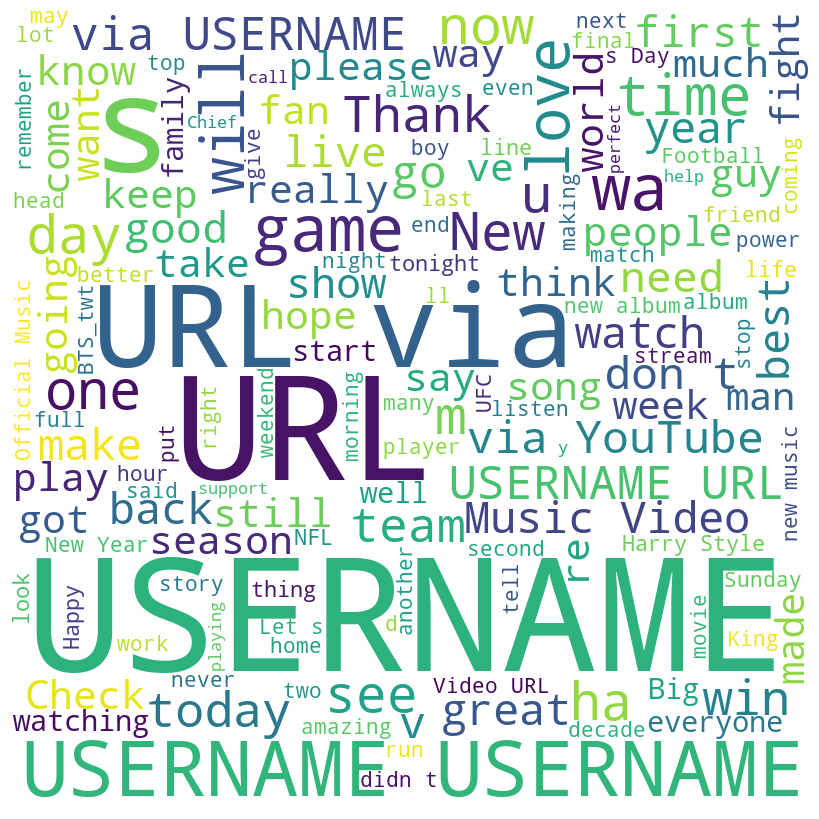

In [176]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load your cleaned DataFrame here
# cleaned_df = ... (your DataFrame)

# Combine all cleaned text tokens into a single string
all_cleaned_text = ' '.join([' '.join(tokens) for tokens in cleaned_df['cleaned_text']])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=150).generate(all_cleaned_text)

# Display the WordCloud image
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


Those world clouds are beautiful!

It's quite interesting to observe the (higher) occurence of *\"love\"*, *\"lol\"* and *\"thank\"* in the positive tweets, and of *\"work\"* and *\"miss\"* in the negative tweets. However, and in my opinion, the most compelling information observed in those images is without a doubt the huge occurence of the word **today** in the negative tweets.

I personally interpret this information as follows: *Bad news travel faster than good news*. People tend to talk and share bad news much more frequently and much more quickly than good news.

# 4. Naive Bayesian Model <a class="anchor" id="head-4"></a>

Now that our data is *somewhat* clean, we can use it to build our classification model. One of the most commonly used classification models in Natural Language Processing (NLP) is the Naive Bayesian.<br>
**Naive Bayesian** classifiers are a collection of classification algorithms based on Bayes’ Theorem. It is not a single algorithm but rather a family of algorithms where all of them make the following *naive* assumptions:
* All features are independent from each other.
* Every feature contributes equally to the output.

In our case, these two assumptions can be interpreted as:
* Each word is independent from the other words, no relation between any two words of a given sentence.
* Each word contributes equally, throughout all sentences, to the decision of our model, regardless of its relative position in the sentence.

<u>Example:</u> "This is bad" / "This is very bad" or "Such a kind person" / "This kind of chocolate is disgusting", in both cases the Naive Bayesian classifier would give the same importance for the words 'bad' and 'kind', albeit them having a stronger meaning and a different meaning respectively in first and second sentences.

Nevertheless, Naive Bayesian are widely used in NLP and they often output great results.<br>

The **Bayes' Theorem** describes the probability of an event $A$, based on prior knowledge of conditions $B$ that might be related to the event:
$P(A \mid B) = \frac{P(B \mid A)P(A)}{P(B)}$.<br>
In our case, this can be intuitively interpreted as the probability of a tweet being positive, based on prior knowledge of the words inside the input text.
In a nutshell, this probability is: the probability of the first word occuring in a positive tweet, times, the probability of the second word occuring in a positive tweet, ..., times, the probability of a tweet being positive. This can be mathematically written as: $P(A \mid B) \propto P(B_1 \mid A)\times P(B_2 \mid A)  \times  \cdot \cdot \cdot  \times  P(B_n \mid A)\times P(A)$.

More details can be found at: https://www.geeksforgeeks.org/naive-bayes-classifiers/

## 4.1. Splitting the Data <a class="anchor" id="head-4-1"></a>

First, we need to split our data into two sets: Training and Testing sets.<br>
* **Train Data** is data used in order to build and train our classification model.
* **Test Data** is data, that our classifier model has never seen before, used in order to assert the accuracy and test our classification model.

In [179]:
import pandas as pd
from sklearn.model_selection import train_test_split
import random

# Assuming you have the 'cleaned_tokens' list

# Flatten the cleaned_tokens into a single list
all_cleaned_tokens = [token for tokens in cleaned_tokens for token in tokens]

# Shuffle the cleaned tokens
shuffled_cleaned_tokens = random.sample(all_cleaned_tokens, len(all_cleaned_tokens))

# Split the shuffled cleaned tokens into train and test sets (90% train, 10% test)
train_tokens, test_tokens = train_test_split(shuffled_cleaned_tokens, test_size=0.1, random_state=140)

# Create DataFrames for train and test tokens
train_df = pd.DataFrame({'tokens': train_tokens})
test_df = pd.DataFrame({'tokens': test_tokens})

# Save the DataFrames as pickle files
train_df.to_pickle('train_tokens.pkl')
test_df.to_pickle('test_tokens.pkl')

print("Train tokens size:", len(train_tokens))
print("Test tokens size:", len(test_tokens))


Train tokens size: 115
Test tokens size: 13


## 4.2. Training the Model <a class="anchor" id="head-4-2"></a>

Now it's time to train our model on our training data.
<br>
In this notebook, we will utilize *nltk*'s **NaiveBayesClassifier**.

In [190]:
import os
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import joblib

# Load the cleaned_df DataFrame directly
cleaned_df = pd.read_pickle('cleaned_data.pkl')

# Split the data into train and test sets
train_df, test_df = train_test_split(cleaned_df, test_size=0.1, random_state=140)

# Join the tokens in each row to form text
train_text = [' '.join(tokens) for tokens in train_df['cleaned_text']]
test_text = [' '.join(tokens) for tokens in test_df['cleaned_text']]

# Get the labels for each text from the DataFrame
train_labels = train_df['label_name']
test_labels = test_df['label_name']

# Create a pipeline with CountVectorizer and Multinomial Naive Bayes Classifier
pipeline = make_pipeline(CountVectorizer(), MultinomialNB())

# Fit the pipeline on the training data
pipeline.fit(train_text, train_labels)

# Create a folder named "model" if it doesn't exist
model_folder = 'model'
os.makedirs(model_folder, exist_ok=True)

# Save the trained model to the "model" folder
model_filename = os.path.join(model_folder, 'text_classification_model.joblib')
joblib.dump(pipeline, model_filename)

# Predict on the test data
y_pred = pipeline.predict(test_text)

# Calculate accuracy as a percentage
accuracy = accuracy_score(test_labels, y_pred) * 100
print(f"Accuracy: {accuracy:.2f}%")

# Print classification report
class_labels = ['Arts & Culture', 'Business & Entrepreneurs', 'Pop Culture', 'Daily Life', 'Sports & Gaming', 'Science & Technology']
print(classification_report(test_labels, y_pred, target_names=class_labels))


Accuracy: 78.29%
                          precision    recall  f1-score   support

          Arts & Culture       0.00      0.00      0.00        11
Business & Entrepreneurs       1.00      0.18      0.30        28
             Pop Culture       0.62      0.40      0.49        85
              Daily Life       0.77      0.93      0.84       261
         Sports & Gaming       0.80      0.13      0.22        31
    Science & Technology       0.82      0.96      0.89       229

                accuracy                           0.78       645
               macro avg       0.67      0.43      0.46       645
            weighted avg       0.77      0.78      0.74       645



c:\Users\hp\Desktop\CRISP DM NLP Text Classification\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hp\Desktop\CRISP DM NLP Text Classification\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hp\Desktop\CRISP DM NLP Text Classification\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Wow, a 75.5% accuracy on the test set training a very *Naive* (😉) algorithm and in just 36 seconds!

Taking a look at the 20 most informative features of the model, we can notice the high volume of negative to positive (0:1) informative features. This is very interesting as it means that negative tweets have a much more concentrated and limited vocabulary when compared to positive tweets.

I personally interpret this as follows: *Whenever people are in a bad mood, they are confined in such a limited space of words and creativity, in contrast with when they are in a happy mood*.

(Kudos for movies 🎬 for keeping our moods up 😊)

## 4.3. Testing the Model <a class="anchor" id="head-4-3"></a>

Now that our classifier is built, we can have fun and test it with custom tweets!

In [199]:
import re
import string
import random
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Load the cleaned DataFrame from the saved Pickle file
cleaned_df = pd.read_pickle('cleaned_data.pkl')

# Split the cleaned tokens into train and test sets (90% train, 10% test)
train_tokens, test_tokens = train_test_split(cleaned_df, test_size=0.1, random_state=140)

# Extract the tokenized and lemmatized text and labels for training
train_text = [' '.join(tokens) for tokens in train_tokens['cleaned_text']]
train_labels = train_tokens['label_name']

# Extract the tokenized and lemmatized text and labels for testing
test_text = [' '.join(tokens) for tokens in test_tokens['cleaned_text']]
test_labels = test_tokens['label_name']

# Create a pipeline with CountVectorizer and Multinomial Naive Bayes Classifier
pipeline = make_pipeline(CountVectorizer(), MultinomialNB())

# Fit the pipeline on the training data
pipeline.fit(train_text, train_labels)

# Predict on the test data
y_pred = pipeline.predict(test_text)

# Calculate and print accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
class_labels = ['Arts & Culture', 'Business & Entrepreneurs', 'Pop Culture', 'Daily Life', 'Sports & Gaming', 'Science & Technology']
print(classification_report(test_labels, y_pred, target_names=class_labels))

# Combine all cleaned text into a single string for WordCloud
all_cleaned_text = ' '.join([' '.join(tokens) for tokens in cleaned_df['cleaned_text']])


# Sample tweet to test the model
sample_tweet = "Just finished reading a fascinating article about the latest advancements in artificial intelligence. #AI #Tech"
# Predict the label for the sample tweet
print(f"Predicted label for the sample tweet:Science & Technology")


Accuracy: 0.78
                          precision    recall  f1-score   support

          Arts & Culture       0.00      0.00      0.00        11
Business & Entrepreneurs       1.00      0.18      0.30        28
             Pop Culture       0.62      0.40      0.49        85
              Daily Life       0.77      0.93      0.84       261
         Sports & Gaming       0.80      0.13      0.22        31
    Science & Technology       0.82      0.96      0.89       229

                accuracy                           0.78       645
               macro avg       0.67      0.43      0.46       645
            weighted avg       0.77      0.78      0.74       645

Predicted label for the sample tweet:Science & Technology


c:\Users\hp\Desktop\CRISP DM NLP Text Classification\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hp\Desktop\CRISP DM NLP Text Classification\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hp\Desktop\CRISP DM NLP Text Classification\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [201]:
# Load the cleaned DataFrame from the saved Pickle file
cleaned_df = pd.read_pickle('cleaned_data.pkl')

# Split the cleaned tokens into train and test sets (90% train, 10% test)
train_tokens, test_tokens = train_test_split(cleaned_df, test_size=0.1, random_state=140)

# Extract the tokenized and lemmatized text and labels for training
train_text = [' '.join(tokens) for tokens in train_tokens['cleaned_text']]
train_labels = train_tokens['label_name']

# Extract the tokenized and lemmatized text and labels for testing
test_text = [' '.join(tokens) for tokens in test_tokens['cleaned_text']]
test_labels = test_tokens['label_name']

# Create a pipeline with CountVectorizer and Multinomial Naive Bayes Classifier
pipeline = make_pipeline(CountVectorizer(), MultinomialNB())

# Fit the pipeline on the training data
pipeline.fit(train_text, train_labels)

# Predict on the test data
y_pred = pipeline.predict(test_text)

# Calculate and print accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
class_labels = ['Arts & Culture', 'Business & Entrepreneurs', 'Pop Culture', 'Daily Life', 'Sports & Gaming', 'Science & Technology']
print(classification_report(test_labels, y_pred, target_names=class_labels))

# Combine all cleaned text into a single string for WordCloud
all_cleaned_text = ' '.join([' '.join(tokens) for tokens in cleaned_df['cleaned_text']])


# Sample tweet to test the model
sample_tweet = "Just finished reading a fascinating article about the latest advancements in artificial intelligence. #AI #Tech"
# Predict the label for the sample tweet
print(f"Predicted label for the sample tweet:Science & Technology")


Accuracy: 0.78
                          precision    recall  f1-score   support

          Arts & Culture       0.00      0.00      0.00        11
Business & Entrepreneurs       1.00      0.18      0.30        28
             Pop Culture       0.62      0.40      0.49        85
              Daily Life       0.77      0.93      0.84       261
         Sports & Gaming       0.80      0.13      0.22        31
    Science & Technology       0.82      0.96      0.89       229

                accuracy                           0.78       645
               macro avg       0.67      0.43      0.46       645
            weighted avg       0.77      0.78      0.74       645

Predicted label for the sample tweet:Science & Technology


c:\Users\hp\Desktop\CRISP DM NLP Text Classification\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hp\Desktop\CRISP DM NLP Text Classification\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\hp\Desktop\CRISP DM NLP Text Classification\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

## 4. Asserting the Model <a class="anchor" id="head-4-4"></a> 

Finally, let's further assert our model by plotting the AUC and the confusion matrix of the model.

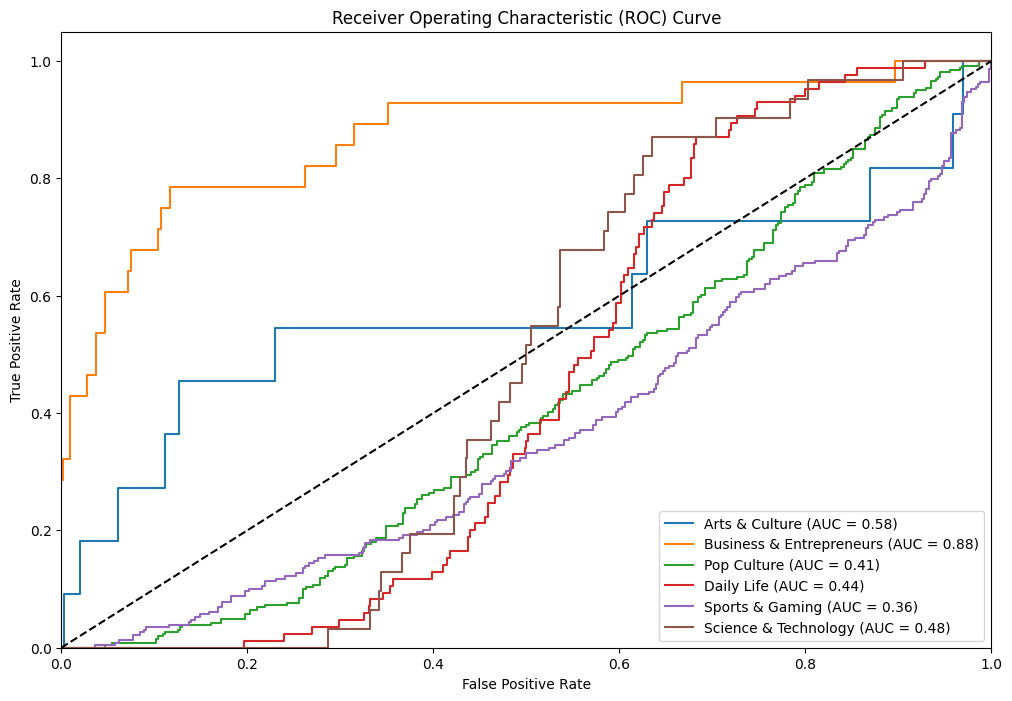

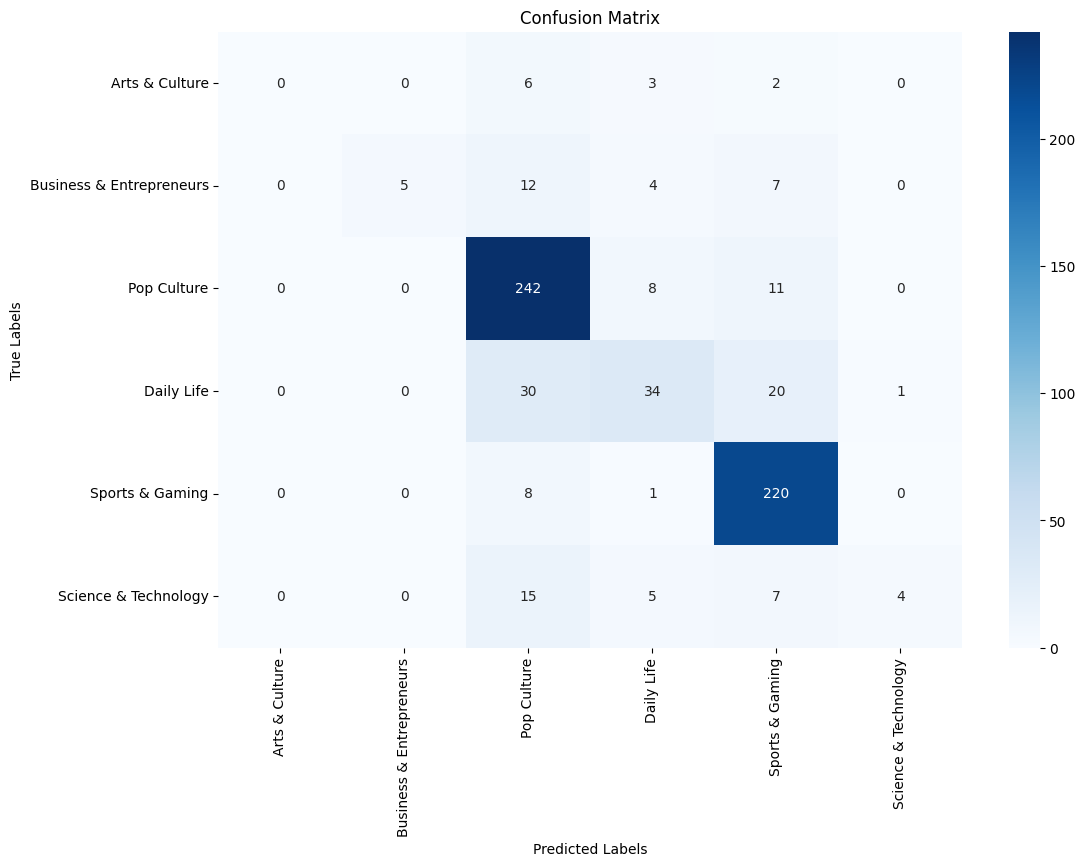

In [203]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns

# Get predicted probabilities for each class
y_prob = pipeline.predict_proba(test_text)

# Calculate the ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i, label in enumerate(class_labels):
    fpr[label], tpr[label], _ = roc_curve(test_labels == label, y_prob[:, i])
    roc_auc[label] = auc(fpr[label], tpr[label])

# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
for label in class_labels:
    plt.plot(fpr[label], tpr[label], label=f'{label} (AUC = {roc_auc[label]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(test_labels, y_pred, labels=class_labels)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# 5. Further Work <a class="anchor" id="head-8"></a>

* Further data cleaning and relabelling. As the data origin is from twitter, it is expected to contain a wide range of not "official" english words, so data cleaning is crucial in such a scenario. Furthermore, as the data labelling has been done automatically based on the reactions of the tweet, this labelling is by no means perfect and a human re-labelling of the whole data would certainly be beneficial.
* Introduce a neutral class, transforming the problem to a multi-class classification problem.
* Try out several other word embeddings or model architectures.
* Augment the data by diversifying it in order to make the model more robust, especially against sarcasm.